In [81]:
ALGORITHM = 'Decision Tree'
ALGORITHM_DETAIL = 'random search'
VERSION = '02'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

In [82]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    ('model', DecisionTreeRegressor())
])

In [83]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored

confirm_colab = False

try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = confirm_colab

if not IN_COLAB:
    import functions_20221012
    from functions_20221012 import set_csv_directory

    set_csv_directory('final_split')

debug_mode = False

In [84]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

booleans = []
floats = ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation']
categories = ['tenure.tenureType']

columns = []
columns.extend(booleans)
columns.extend(floats)
columns.extend(categories)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['location.latitude', 'location.longitude', 'bedrooms', 'bathrooms', 'nearestStation', 'tenure.tenureType']
label ->  Price


In [85]:
filename = f'df_listings_v{VERSION}.csv'
#remote_pathname = 'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings.csv'
remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
df_pathname_raw = f'../../data/source/{filename}'
df_pathname_tidy = f'../../data/final/{filename}'


def get_source_dataframe(rows=cutdown_rows, folder_prefix='../'):

    retrieval_type = None

    if IN_COLAB:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', remote_pathname)
    else:
        try:
            inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
            retrieval_type = 'tidy'
            print('loaded data from', df_pathname_tidy)
        except:
            print(f"WARNING: Failed to retrieved stored data for version {VERSION}, creating new source data.")
            inDF = functions_20221012.get_combined_dataset(HOW='inner', early_duplicates=True,
                                                            folder_prefix=folder_prefix)
            inDF.to_csv(df_pathname_raw)
            retrieval_type = 'raw'

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type


def create_train_test_data(df_orig, return_index=False, drop_nulls=True):
    df = df_orig.copy()

    if drop_nulls:
        df.dropna(inplace=True)

    if return_index:
        df.reset_index(inplace=True)

    for column in categories:
        df = pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1)
        df.drop([column], axis=1, inplace=True)  # now drop the original column (you don't need it anymore),

    ins = df.pop('index')
    df.insert(1, 'index2', ins)
    df.insert(0, 'index', ins)

    #features = df[df.columns[1:]].values
    features = df[df.columns[2:]].values
    #labels = df[LABEL].values
    labels = df.iloc[:, 0:2].values

    if not return_index:
        return train_test_split(features, labels, train_size=0.9, random_state=RANDOM_STATE)
    else:
        X_train1, X_test1, y_train1, y_test1 = train_test_split(features, labels, train_size=0.9, random_state=RANDOM_STATE)
        X_train_index = X_train1[:, 0].reshape(-1, 1)
        y_train_index = y_train1[:, 0].reshape(-1, 1)
        X_test_index = X_test1[:, 0].reshape(-1, 1)
        y_test_index = y_test1[:, 0].reshape(-1, 1)
        X_train1 = X_train1[:, 1:]
        y_train1 = y_train1[:, 1].reshape(-1, 1)
        X_test1 = X_test1[:, 1:]
        y_test1 = y_test1[:, 1].reshape(-1, 1)

        return X_train1, X_test1, y_train1, y_test1, X_train_index, X_test_index, y_train_index, y_test_index

#X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(get_source_dataframe(), return_index=True, drop_nulls=False)
#X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape, y_train_index.shape, y_test_index.shape,

In [86]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../')
df_orig = df.copy()


if retrieval_type != 'tidy':
    df = functions_20221012.add_supplements(df)
    df.to_csv(df_pathname_raw)
    df = functions_20221012.tidy_dataset(df, version=int(VERSION))

    df = df[columns]

    df.to_csv(df_pathname_tidy)

print(df.shape)
df[:5]

df_orig.merge(df, how='inner', left_index=True, right_index=True)

print(df.index)

loaded data from ../../data/final/df_listings_v02.csv
(52117, 7)
Int64Index([ 14520525,  27953107,  33593487,  35271294,  35429088,  44749111,
             46204665,  49020666,  49036279,  49303873,
            ...
            126173423, 126173600, 126175973, 126178769, 126179018, 126179672,
            126180107, 126180704, 126180962, 126181118],
           dtype='int64', length=52117)


In [87]:
df

,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType
14520525,550000.0,51.52995,-0.207020,3.0,1.0,0.274316,LEASEHOLD
27953107,400000.0,51.54939,-0.482600,2.0,2.0,0.305845,LEASEHOLD
33593487,579950.0,51.44718,-0.338770,2.0,1.0,0.438045,FREEHOLD
35271294,370000.0,51.449568,-0.140154,2.0,1.0,0.399307,LEASEHOLD
35429088,599950.0,51.57703,-0.141230,2.0,1.0,0.238187,NaN
...,...,...,...,...,...,...,...
126179672,600000.0,51.35717,-0.074740,3.0,2.0,0.545665,LEASEHOLD
126180107,419999.0,51.531415,-0.052964,2.0,1.0,0.191407,LEASEHOLD
126180704,475000.0,51.543141,0.011498,2.0,1.0,0.308609,LEASEHOLD
126180962,450000.0,51.592105,-0.008233,NaN,1.0,0.476935,FREEHOLD


In [88]:
df.isnull().sum()

Price                    0
location.latitude        0
location.longitude       0
bedrooms              1742
bathrooms             3173
nearestStation           0
tenure.tenureType     3402
dtype: int64

In [89]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52117 entries, 14520525 to 126181118
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Price               52117 non-null  float64
 1   location.latitude   52117 non-null  object 
 2   location.longitude  52117 non-null  float64
 3   bedrooms            50375 non-null  float64
 4   bathrooms           48944 non-null  float64
 5   nearestStation      52117 non-null  float64
 6   tenure.tenureType   48715 non-null  object 
dtypes: float64(5), object(2)
memory usage: 5.2+ MB


,Price,location.longitude,bedrooms,bathrooms,nearestStation
count,52117.000000,52117.000000,50375.000000,48944.000000,52117.000000
mean,419854.956790,-0.104810,11.721787,1.177182,0.445245
std,110342.806124,0.731478,2183.166275,0.410552,1.066809
min,100000.000000,-0.498315,1.000000,1.000000,0.000000
25%,330000.000000,-0.211852,1.000000,1.000000,0.224233
50%,425000.000000,-0.104440,2.000000,1.000000,0.363994
75%,500000.000000,-0.011509,3.000000,1.000000,0.557263
max,600000.000000,51.558746,490000.000000,12.000000,192.431869


In [90]:
old_length = len(df)
df['location.latitude'] = pd.to_numeric(df['location.latitude'], 'coerce').dropna().astype(float)
df = df[(df['location.longitude'] <= 10)]
df = df[(df['bedrooms'] <= 10)]
df = df[df['bathrooms'] <= 5]
df = df[(df['nearestStation'] <= 20)]

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 52117 ==> 47444


,count,mean,std,min,25%,50%,75%,max
Price,47444.0,424032.547382,108060.063745,100000.000000,345000.000000,425000.000000,511500.000000,600000.000000
location.latitude,47444.0,51.496962,0.077034,51.298317,51.438814,51.499890,51.555916,51.683185
location.longitude,47444.0,-0.113297,0.156316,-0.498315,-0.210785,-0.102333,-0.010485,0.279726
bedrooms,47444.0,1.990557,0.828428,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,47444.0,1.182173,0.410188,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,47444.0,0.439824,0.354467,0.000000,0.226450,0.367506,0.558826,16.168861


In [91]:
df.isna().sum()

Price                    0
location.latitude        0
location.longitude       0
bedrooms                 0
bathrooms                0
nearestStation           0
tenure.tenureType     2780
dtype: int64

In [92]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

47444 ==> 44664


,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation
count,44664.000000,44664.000000,44664.000000,44664.000000,44664.000000,44664.000000
mean,424197.633598,51.496602,-0.113125,1.989208,1.181332,0.439504
std,107989.580699,0.077221,0.155684,0.827142,0.409031,0.353470
min,100000.000000,51.298317,-0.498315,1.000000,1.000000,0.000000
25%,345000.000000,51.438246,-0.210584,1.000000,1.000000,0.226771
50%,425000.000000,51.498681,-0.101934,2.000000,1.000000,0.367875
75%,515000.000000,51.555979,-0.010933,3.000000,1.000000,0.558693
max,600000.000000,51.683185,0.279726,7.000000,5.000000,16.168861


In [93]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index = create_train_test_data(df,
                                                                                                                    return_index=True,
                                                                                                                    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)
#print(type(X_train))
#X_train[0]

(40197, 9) (4467, 9) (40197, 1) (4467, 1) (40197, 1) (4467, 1) (40197, 1) (4467, 1)


In [94]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [95]:
from time import time

#pipe.fit(X_train, y_train)

model = DecisionTreeRegressor()
#model.fit(X_train, y_train)
model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [96]:

from sklearn.pipeline import Pipeline

# Best Score:  0.30582573121661794
# Best Score:  {'alpha': 10, 'fit_intercept': True, 'max_iter': 1000, 'positive': False, 'selection': 'cyclic', 'tol': 0.001, 'warm_start': True}
# Best Score:  Lasso(alpha=10, tol=0.001, warm_start=True)
# Best Score:  138

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

# find optimal alpha with grid search
ccp_alpha = [0, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
criterion = ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
max_depth = [None, 1, 2, 3, 5, 10, 20]
max_features = [1, 2, 3, 5, 10, 20, len(columns)]
max_leaf_nodes = [2, 3, 5, 10, 20]
min_impurity_decrease = [None, 0, 1, 2, 3, 5]
min_samples_leaf = [1, 2, 3, 5]
min_samples_split = [2, 3, 5, 10]
min_weight_fraction_leaf = [0.1, 0.2, 0.3, 0.5]
splitter = ['best', 'random']

max_iter = [100, 1000, 10000]

options__n_neighbours = [3, 5, 7, 9, 15, 31]
options__leafsize = [2, 3, 4, 57, 9, 13, 21]

param_grid = dict(model__ccp_alpha=ccp_alpha, model__criterion=criterion, model__max_depth=max_depth,
                  model__max_features=max_features, model__max_leaf_nodes=max_leaf_nodes, model__min_impurity_decrease=min_impurity_decrease,
                  model__min_samples_leaf=min_samples_leaf, model__min_samples_split=min_samples_split, model__min_weight_fraction_leaf=min_weight_fraction_leaf,
                  model__splitter=splitter
                  )

cv = 3
n_jobs = 1
verbose = 1
refit = True

#grid = RandomizedSearchCV(estimator=model, param_grid=param_grid, scoring='r2', verbose=1, n_jobs=-1)

gs = RandomizedSearchCV(pipe, param_grid, cv=cv, n_jobs=n_jobs,
                        verbose=verbose, scoring=CROSS_VALIDATION_SCORING, refit=refit,
                        return_train_score=True, n_iter=300),
gs

grid_result = gs[0].fit(X_train, y_train)


Fitting 3 folds for each of 300 candidates, totalling 900 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
159 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
159 fits failed with the following error:
Traceback (most recent call last):
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/guava/PycharmProjects/capstone_

In [97]:
pipe = grid_result.best_estimator_
timings = []

t0 = time()
pipe.fit(X_train, y_train)
timings.append(time() - t0)

print(timings)
average_time = sum(timings) / len(timings)
print(average_time)

[0.06770491600036621]
0.06770491600036621


In [98]:
def print_results(results):
    print(f'BEST PARAMS: {results.best_params_}')

    means = results.cv_results_['mean_test_score']
    stds = results.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, results.cv_results_['params']):
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) for {params}')


print_results(grid_result)
print('Best Index: ', grid_result.best_index_)
print('Best Score: ', grid_result.best_score_)
print('Best Params: ', grid_result.best_params_)
#print('Best Model: ', grid_result.)
#print('Best Params: ', grid_result.best_params_)[out]
### Best Score:  0.4883436188936269
### Best Params:  {'alpha': 0.01}


BEST PARAMS: {'model__splitter': 'best', 'model__min_weight_fraction_leaf': 0.1, 'model__min_samples_split': 3, 'model__min_samples_leaf': 5, 'model__min_impurity_decrease': 5, 'model__max_leaf_nodes': 10, 'model__max_features': 20, 'model__max_depth': 20, 'model__criterion': 'squared_error', 'model__ccp_alpha': 100}
0.07 (+/-0.107) for {'model__splitter': 'random', 'model__min_weight_fraction_leaf': 0.2, 'model__min_samples_split': 3, 'model__min_samples_leaf': 2, 'model__min_impurity_decrease': 1, 'model__max_leaf_nodes': 3, 'model__max_features': 2, 'model__max_depth': None, 'model__criterion': 'absolute_error', 'model__ccp_alpha': 100}
-0.0 (+/-0.0) for {'model__splitter': 'random', 'model__min_weight_fraction_leaf': 0.5, 'model__min_samples_split': 2, 'model__min_samples_leaf': 5, 'model__min_impurity_decrease': 3, 'model__max_leaf_nodes': 5, 'model__max_features': 3, 'model__max_depth': 20, 'model__criterion': 'poisson', 'model__ccp_alpha': 1000}
0.132 (+/-0.01) for {'model__spli

In [99]:
y_pred = pipe.predict(X_test)

In [100]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Decision Tree----------
R square Accuracy 0.27728988246800357
Mean Absolute Error Accuracy 74554.95855918912
Mean Squared Error Accuracy 8269820617.092809
Root Mean Squared Error 90938.55407412638


In [101]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [102]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(str)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
124597034.0,285000.0,350371.100945,65371.100945,22.937228,18.657675
82883871.0,500000.0,511432.481697,11432.481697,2.286496,2.235384
123298382.0,435000.0,406065.558915,28934.441085,6.651596,7.125559
119192408.0,300000.0,383172.979763,83172.979763,27.724327,21.706379
116845355.0,600000.0,487015.483829,112984.516171,18.830753,23.199368
...,...,...,...,...,...
123467048.0,449950.0,403490.787198,46459.212802,10.325417,11.514318
114663482.0,375000.0,403490.787198,28490.787198,7.597543,7.061075
123013478.0,500000.0,383172.979763,116827.020237,23.365404,30.489368


In [103]:
compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'], ascending=False)

,actual,predicted,difference,diff 1 %,diff 2 %,Price,location.latitude,location.longitude,bedrooms,bathrooms,nearestStation,tenure.tenureType


In [104]:
score = pipe.score(X_test, y_test)
score

0.27728988246800357

In [105]:
from sklearn.metrics import r2_score

r2_score(y_test, y_pred)

0.27728988246800357

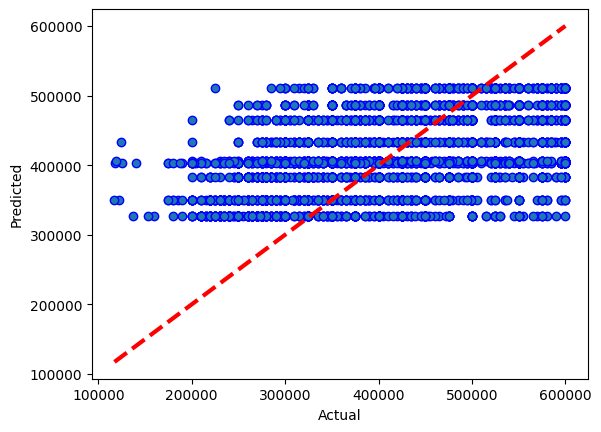

In [106]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.scatter(y_test, pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [118]:
def score_summary(self, sort_by='mean_score'):
    def row(key, scores, params):
        d = {
            'estimator': key,
            'min_score': min(scores),
            'max_score': max(scores),
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
        }
        #return pd.Series({**params, **d})
        return pd.Series({**params, **d, **{'params_full': str(params)}})

    rows = []
    for k in self.grid_searches:
        print(k)
        params = self.grid_searches[k].cv_results_['params']
        scores = []
        for i in range(self.grid_searches[k].cv):
            key = "split{}_test_score".format(i)
            r = self.grid_searches[k].cv_results_[key]
            scores.append(r.reshape(len(params), 1))

        all_scores = np.hstack(scores)
        for p, s in zip(params, all_scores):
            rows.append((row(k, s, p)))

    df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

    columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
    columns = columns + [c for c in df.columns if c not in columns]

    return df[columns]

import seaborn as sns

score_summary = score_summary(self=gs, sort_by='max_score')

/snap/pycharm-professional/302/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_utils.py:606: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in s.iteritems():
/snap/pycharm-professional/302/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_utils.py:606: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in s.iteritems():
/snap/pycharm-professional/302/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_utils.py:606: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in s.iteritems():
/snap/pycharm-professional/302/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_utils.py:606: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in s.iteritems():
/snap/pycharm-professional/302/plugins/python/helpers/pydev/_pydevd_bundle/pydevd_utils.py:606: Futu

AttributeError: 'tuple' object has no attribute 'grid_searches'

In [110]:

if True:
    #sns.set(rc={"figure.figsize": (10, 10)})
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    #total_graphs = len(score_summary)
    # max_horizontal = 4
    # index2 = 0
    # resultant_rows = math.ceil(total_graphs / max_horizontal)
    # #subplots_adjust()
    #
    # #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    best_estimator = score_summary.iloc[0]
    worst_estimator = score_summary.iloc[-1]

    name_best = best_estimator["estimator"]
    params_str = best_estimator["params_full"]
    params_best = ast.literal_eval(params_str)

    name_worst = worst_estimator["estimator"]
    params_str = worst_estimator["params_full"]
    params_worst = ast.literal_eval(params_str)

    KNeighborsRegressor().set_params()

    best_pipe = make_pipe(name_best)
    worst_pipe = make_pipe(name_worst)

    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test, y=best_pipe.set_params(**params_best).fit(X_train, y_train).predict(X_test), ax=axes[0], s=100).set(
        title=f'"BEST" model: {name_best} \n{params_best}')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test, y=worst_pipe.set_params(**params_worst).fit(X_train, y_train).predict(X_test), ax=axes[1], s=100).set(
        title=f'"WORST" model: {name_worst} \n{params_worst}')

    sns.scatterplot(x=y_test, y=worst_pipe.set_params(**params_worst).fit(X_train, y_train).predict(X_test), ax=axes[2], s=100, color='orange')
    sns.scatterplot(x=y_test, y=best_pipe.set_params(**params_best).fit(X_train, y_train).predict(X_test), ax=axes[2], s=100, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')

    fig.tight_layout()
    plt.show()

if True:
    max_horizontal = 3

    #sns.set()
    #sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)
    sns.set(rc={"figure.figsize": (20, 20)})
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    total_graphs = len(score_summary)
    index2 = 0
    resultant_rows = math.ceil(total_graphs / max_horizontal)
    #subplots_adjust()

    #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
    fig, axes = plt.subplots(nrows=2, ncols=max_horizontal, figsize=(15, 10))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    for (key, next_estimator), index in zip(score_summary.iterrows(), range(total_graphs)):
        if index % (max_horizontal * 2) == 0 and index != 0:
            index2 = 0
            fig.tight_layout()
            plt.show()
            #fig, axes = plt.subplots(nrows=resultant_rows, ncols=max_horizontal)
            fig, axes = plt.subplots(nrows=2, ncols=max_horizontal, figsize=(15, 10))

        name_next = next_estimator["estimator"]
        params_str = next_estimator["params_full"]
        params_next = ast.literal_eval(params_str)
        #print("next", params_next)

        if 'noscale' in name_next:
            pipe = Pipeline(steps=[
                ('preprocessor', features_noscale_preprocessor),  # preprocess features
                ('estimator', models_and_params[name_next]["model"]),
            ])  # start the training
        else:
            pipe = Pipeline(steps=[
                ('preprocessor', features_preprocessor),
                ('estimator', models_and_params[name_next]["model"]),  # preprocess features
            ])  # start the training

        # 0 ==> 0,0
        # 1 ==> 0,1
        # 2 ==> 1,0
        x_coor = index2 // max_horizontal
        y_coor = index2 % max_horizontal

        coordinates = axes[x_coor][y_coor]
        #sns.lineplot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], hue='red', lw=3)
        sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=coordinates, color='red')
        sns.scatterplot(x=y_test, y=pipe.set_params(**params_next).fit(X_train, y_train).predict(X_test), ax=coordinates, s=100).set(
            title=f'({index}) {"BEST" if index == 0 else "next"} model: {name_next} \n{params_next}')
        #if index == 11: break
        index2 += 1

    fig.tight_layout()
    plt.show()

NameError: name 'score_summary' is not defined

In [107]:
from datetime import datetime

results = {
    'Score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    'Training Time': average_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now())
}
import json


def update_results():
    results_filename = '../../results/results.json'

    with open(results_filename) as f:
        raw_audit = f.read()
    results_json = json.loads(raw_audit)

    results_json[f'{ALGORITHM} - {ALGORITHM_DETAIL} (v{VERSION})'.lower()] = results

    with open(results_filename, 'w') as file:
        file.write(json.dumps(results_json, indent=4))


if not IN_COLAB:
    update_results()

results

{'Score': 0.27728988246800357,
 'R square Accuracy': 0.27728988246800357,
 'Mean Absolute Error Accuracy': 74554.95855918912,
 'Mean Squared Error Accuracy': 8269820617.092809,
 'Root Mean Squared Error': 90938.55407412638,
 'Training Time': 0.06770491600036621,
 'random_state': 101,
 'date': '2022-10-12 18:32:00.759091'}